# Introduction

- The original pepar could be found [here](https://arxiv.org/pdf/1506.02640v5.pdf).

- I am kent and this artical is actually inspired by many other works, and I put all these amazing works in reference.

# Core Concept

- The core concept of the Darknet with YOLO is about the encoded pairs of **input image tensor** and **output tensor**, which is quite different from **output one-hot vector** in general case. 

- The process of encoded tensor is kinds handcafted and is **independent to** the convnet itself.

- The convnet is just trying to fit the output tensor.

- YOLO divides the input image into an S × S grid.

- **If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object**. 

- Which is means the grid is about (448/7, 448/7) = (64,64) in resolution

$$ \text{Output } = F_\text{cnn}(\text{ Input }) $$

$$ \text{Input } : X \in \mathbb{R}^{448\times448\times3}$$

$$ \text{Output } : Y \in \mathbb{R}^{S\times S\times (B\times5+C)}$$

where

$$ \text{Grid Numbers} : S \times S \text{ where, } S \in \{\ \text{ Factors of img w or h}\,\}$$

$$ \text{Bounding Box Numbers} : B \ \text{ for each } B \equiv \{\ \text{x1, y1, wid, height, confidence score}\, \}$$

$$ \text{Classes Numbers} : C \in \{\ \text{Number of Objects such as cars, cat ...} \} $$

In [ ]:
def read_from_img(img):
    img = cv2.resize(img, (448,448), cv2.IN...)
    return img

INPUT = read_from_img(img)
OUTPUT = NN.predict_forward(INPUT)


# What is the Predicting Bounding Box really representing ?

- Each bounding box consists of 5 predictions: { x, y, w, h,and confidence}. 

- The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell. 

- The width and height are predicted relative to the whole image. 

- Finally the confidence prediction represents the IOU between the predicted box and any ground truth box.

# What is Condence Score really representing ?

- The **confidence score** here is well defined

- These confidence scores reflect how confident the model is that the box contains an object andalso how accurate it thinks the box is that it predicts

- If **no object** exists in that cell, the **confidence scores should be zero**. 

- Otherwise we want the confidence score to equal **the intersection over union (IOU)** between the predicted box and the ground truth

$$ \Pr ( \text{Objects} ) \times \text{IOU}^{pred}_{truth} $$

$$
\Pr ( \text{Objects} ) =
\begin{cases}
1,& \text{ if there are objects } \\
0,& \text{ if no object exiests }
\end{cases}
$$


# What is IOU really representing ?

- The intersection over union of ture bounding box and predicted bonding box

- It is a percentage.

- Each predicted box will have a IOU vs ground turth bonding box

- 

# What is the Classes Numbers really representing ?

- $C$ is, in fact, the number of probabilities that descibing how many chances a single grid could be classified as what classes, a car ? or a dog ? or ... ?

- For a trained pair, the grid that contains the center of the target-bounding box for each class, is actually a one-hot-vector. 

- For a trained pair, the grid that does not contain any center of the target-bounding box, is actually a all-zeron-vector.

- Each grid cell also predicts C conditional class probabilities,Pr(Classi|Object). These probabilities are conditioned on the grid cell containing an object.

- We only predict one set of class probabilities per grid cell, regardless of the number of boxes B

# Interpret Output Tensor

- At test time YOLO multipy the conditional class probabilities and the individual box confiddence predictions

- It will give class-specific confience scores for each box

- These scores encode both the probability of that class appearing in the box and how well the predicted box fits the objects

$$ \Pr ( \text{Class}_{i} \mid \text{Object} ) \times \text{IOU}^{\text{truth}}_{\text{predict}} = \Pr( \text{Class}_{i})  \times  \text{IOU}^{\text{truth}}_{\text{predict}} $$


# Some Insights about Encoded Output Tensor (EOT)

- Very Sparse, much more sparse that triditional one-hot-vector encoder due to the tensor dimension is basically larger.

- 


# Customize the loss function 

- Final layer predicts both class probabilities and bounding box coordinates. (2 jointed pipe)

- The bounding box wid and height are normalized by the image resolusion (448,448) in order to make the prediction values fall between 0 and 1

- The bounding box x, y coordinates are parameterized to be offsets of a particular grid cell location so they are also bounded between 0 and 1

- The Final Layer is RELU and the rest of layers use the leaky RELU with alpha level =0.1

$$
\text{LeakyRELU} ( X ) =
\begin{cases}
X,& \text{ if X >  0 } \\
0.1X,& \text{ otherwise }
\end{cases}
$$

# Sum-Squard error of the output tensor with penalty

- We use sum-squared error because it is easy to optimize, however it does not perfectly align with our goal of maximizing average precision.

- It weights localization error equally with classification error which may not be ideal.

- Also, in every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. 

- This can lead to model instability, causing training to diverge early on.

- To remedy this, we increase the loss from **bounding box coordinate predictions** and decrease the loss from **confidence predictions for boxes that don’t contain objects**. 

- We use two parameters, λcoord and λnoobj to accomplish this. 

- We set λcoord = 5 and λnoobj = .5.

- Sum-squared error also equally weights errors in large boxes and small boxes. 

- Our error metric should reflect that small deviations in large boxes matter less than in small boxes. 

- To partially address this we predict the square root of the bounding box width and height instead of the width and height directly.



In [48]:
import numpy as np

train_x = []
for i in range(1000):
    train_x.append(np.random.randint(low=0,high=255,size=(100, 100)))
    
print np.array(train_x).shape

(1000, 100, 100)


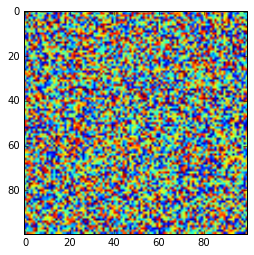

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_x[1])

In [ ]:
# Define Activation
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# Define 

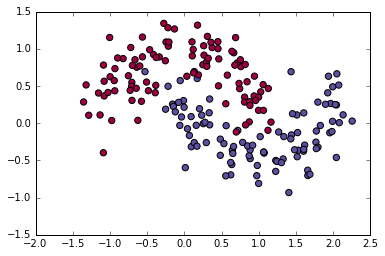

In [22]:
import sklearn.datasets as datasets
# Generate a dataset and plot it
np.random.seed(0)
X, y = datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [26]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

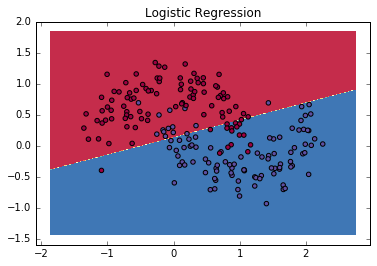

In [27]:
from sklearn import linear_model
# Train the logistic rgeression classifier
clf = linear_model.LogisticRegressionCV()
clf.fit(X, y)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

In [15]:
from IPython.core.display import HTML
HTML("""<style>
div.text_cell_render p {font-size: 1.4em;line-height:1.4em;text-align:left;}
div.text_cell_render li {font-size: 1.0em;line-height:1.6em;text-align:left;}
div.text_cell_render h1 {font-size: 1.6em;line-height:1.6em;text-align:left; }
div.container pre{font-family: Monaco;font-size: 1.2em;line-height:1.2em;}
</style>""")

# Reference 

- [YOLO PPT](https://docs.google.com/presentation/d/1kAa7NOamBt4calBU9iHgT8a86RRHz9Yz2oh4-GTdX6M/edit#slide=id.g151008b386_0_0)